In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import os
import pprint
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tqdm
from tensorflow.keras.constraints import max_norm
from keras.callbacks import TensorBoard

2024-02-01 11:24:52.354757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 11:24:52.528762: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 11:24:53.174734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/raid/home/labuserdia/.conda/envs/DLexp/lib/
2024-02-01 11:24:53.174839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'

In [2]:
!nvidia-smi

/bin/bash: /raid/home/labuserdia/.conda/envs/DLexp/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu Feb  1 11:25:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0    41W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+--------

## Signal generation

In [3]:
def score(N_used, N_hold, B, I):
    return ((N_used/N_hold)*B*I) * np.sqrt(N_used)

In [4]:
score(50,200,3,6)

31.81980515339464

In [5]:
def gen_N(L,mu,sigma,A,B):
    raw_numbers = np.random.normal(mu, sigma, L)
    rounded_numbers = np.round(raw_numbers).astype(int)
    return np.clip(rounded_numbers, A, B)

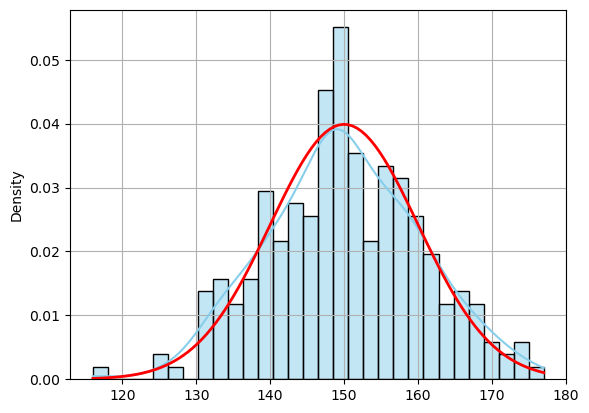

In [6]:
L = 250
mu = 150
sigma = 10
A = 1
B = 500
# count, bins, ignored = plt.hist(gen_N(L,mu,sigma), 30, density=True)
# plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
data = gen_N(L,mu,sigma,A,B)
sns.histplot(data, bins=30, kde=True, stat="density", color='skyblue')

# Plot the theoretical normal distribution curve
x = np.linspace(min(data), max(data), 100)
y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))
plt.plot(x, y, linewidth=2, color='r')
plt.grid()

# Show the plot
plt.show()

The function generates L number following the normal/gaussian distribution.

<Axes: ylabel='Density'>

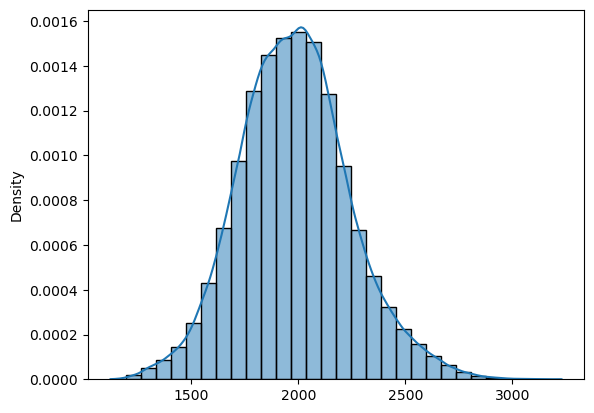

In [7]:
"""
Function that generates L synthetic scores.
@param:
    N_used : Nomber of token used
    N_hold : Number of token hold
    B : Constant representing the given bonus for a specific action
    I : Factor equals to the total of month for the participation in the operation
    L : number of scores generated
"""
def gen_scores(B, L):
    list_score = np.array([])
    
    mu = L/2
    sigma = 10
    
    list_N_used = gen_N(L,mu,sigma,10, 2*L)
    list_N_used = np.array(list_N_used)
    list_N_hold = list_N_used + np.array(gen_N(L, mu, sigma, 0, L))
    list_I = np.array(gen_N(L,mu,30,1, 2*L))
    
    for k in range(L):
        s = score(list_N_used[k], list_N_hold[k], B, list_I)
        list_score = np.append(list_score, s)
        
    return np.array(list_score)


sns.histplot(gen_scores(1,500), bins=30, kde=True, stat="density")

## Wallets dataframe modelisation

In [8]:
L = 500
STACKING = 1
LP = 2
BUY = 3
HOLD = 4
VOTE = 5

list_stacking = gen_scores(STACKING, L)
print("STACKING DONE")

list_lp = gen_scores(LP, L)
print("LP DONE")

list_buy = gen_scores(BUY, L)
print("BUY DONE")

list_hold = gen_scores(HOLD,L)
print("HOLD DONE")

list_vote = gen_scores(VOTE, L)
print("VOTE DONE")

STACKING DONE
LP DONE
BUY DONE
HOLD DONE
VOTE DONE


In [9]:

def gen_numbers_summing_to_1():
    # Generate four random numbers between 0 and 1
    a, b, c, d, e = np.random.uniform(0, 1, 4)

    # Normalize the numbers to ensure the sum is equal to 1
    normalization_factor = a + b + c + d
    a /= normalization_factor
    b /= normalization_factor
    c /= normalization_factor
    d /= normalization_factor

    # Return the four normalized numbers
    return a, b, c, d

def gen_N_1(L):
    l= []
    for k in range(L):
        l.append(gen_numbers_summing_to_1())
    return l

In [10]:
L = 1000
pre_df = {
    'stacking1' : gen_scores(STACKING, L),
    'LP1' : gen_scores(LP, L),
    'buy1' : gen_scores(BUY, L),
    'hold1' : gen_scores(HOLD, L),
    'vote1' : gen_scores(VOTE, L),
    'stacking2' : gen_scores(STACKING, L),
    'LP2' : gen_scores(LP, L),
    'buy2' : gen_scores(BUY, L),
    'hold2' : gen_scores(HOLD, L),
    'vote2' : gen_scores(VOTE, L),
    'stacking3' : gen_scores(STACKING, L),
    'LP3' : gen_scores(LP, L),
    'buy3' : gen_scores(BUY, L),
    'hold3' : gen_scores(HOLD, L),
    'vote3' : gen_scores(VOTE, L),
    'stacking4' : gen_scores(STACKING, L),
    'LP4' : gen_scores(LP, L),
    'buy4' : gen_scores(BUY, L),
    'hold4' : gen_scores(HOLD, L),
    'vote4' : gen_scores(VOTE, L),
    'stacking5' : gen_scores(STACKING, L),
    'LP5' : gen_scores(LP, L),
    'buy5' : gen_scores(BUY, L),
    'hold5' : gen_scores(HOLD, L),
    'vote5' : gen_scores(VOTE, L),
    'stacking6' : gen_scores(STACKING, L),
    'LP6' : gen_scores(LP, L),
    'buy6' : gen_scores(BUY, L),
    'hold6' : gen_scores(HOLD, L),
    'vote6' : gen_scores(VOTE, L)
}

wallet_df = pd.DataFrame(pre_df)
wallet_df.head(10)

,stacking1,LP1,buy1,hold1,vote1,stacking2,LP2,buy2,hold2,vote2,...,stacking5,LP5,buy5,hold5,vote5,stacking6,LP6,buy6,hold6,vote6
0,4870.604979,11998.869566,18038.700579,23709.653198,31813.051144,5854.388416,11426.027937,16617.907392,22337.672178,29994.316987,...,5629.901840,10302.257570,18043.096946,20530.765528,31260.468741,6648.168306,11965.492499,16776.702833,23943.763189,26149.829043
1,5087.076311,10541.062983,17723.461151,22114.237282,30147.747023,5560.580819,11158.230407,16617.907392,23181.441107,26661.615100,...,5751.809164,10648.551942,17702.661154,21512.671705,29086.338396,4988.910220,11231.975718,17951.724821,23187.175876,25587.467128
2,5833.902408,10473.779603,19930.137144,24019.872960,27448.805861,5310.300273,11582.243163,17445.492422,21627.129921,25405.022585,...,5441.499614,10064.180189,17634.573996,22539.209981,30437.824827,5155.949624,11873.802902,15242.646348,20917.413938,31436.031044
3,5552.489676,12088.580741,16357.423631,22291.505717,29860.625623,5386.472613,10377.154279,15790.322363,24780.161183,26333.808357,...,5718.561712,11341.140686,18689.924950,23208.691466,31613.030419,5222.765386,12217.638893,16907.260831,20917.413938,30367.543405
4,4848.957845,10630.774158,18423.993212,22734.676805,28769.564302,5462.644953,10756.534113,16319.976782,21493.903248,28628.455558,...,5286.344838,10648.551942,16885.615255,20352.237132,27029.728611,5300.717109,11231.975718,14165.542859,20783.898530,25025.105214
5,5249.429810,11527.885901,18388.966609,20917.675345,31927.899704,5549.699056,9975.457984,14896.530531,21538.312139,28519.186644,...,5596.654389,11882.225643,16545.179464,21825.096398,30320.304268,6469.992941,11117.363721,15960.715341,22030.042339,26599.718575
6,5595.783942,11281.180172,20455.536190,22202.871500,31066.535504,6061.141910,11649.192545,15955.839369,20960.996556,26825.518471,...,5375.004710,10064.180189,16987.745992,22985.530971,29967.742590,5556.844196,10979.829324,17560.050825,21896.526931,31885.920575
7,5444.254009,10698.057539,16357.423631,21759.700412,27563.654421,5963.206045,10667.268269,15459.288351,22115.627722,26169.904985,...,6261.603425,10323.900968,15694.089985,20977.086517,29380.139794,5846.379164,11048.596522,16025.994340,22608.609107,26206.065235
8,5141.194144,10496.207396,15726.944776,22380.139935,28310.170062,5712.925499,9997.774445,16584.803991,22426.489960,27371.863043,...,5064.695160,11384.427483,17872.879050,22316.049487,28616.256160,5924.330886,12080.104496,17266.295328,20605.877986,28061.859554
9,5076.252744,11998.869566,18248.860197,23975.555851,31813.051144,5517.053768,11693.825467,15823.425764,21760.356594,25623.560413,...,5109.025095,11276.210492,15660.046406,23030.163070,29556.420633,5657.067838,11048.596522,17560.050825,21584.990978,26937.135724


## NN modelisation

### Hyperparameters

In [12]:
learning_rate = 0.001
batch_size = 128
num_epochs = 150

In [13]:
def getNN():
    input1 = layers.Input(shape=(5,))
    x1 = layers.Dense(128)(input1)
    x1 = layers.Dense(256,activation = 'sigmoid')(x1)
    x1 = layers.Dense(256,activation = tf.nn.relu)(x1)
    x1 = layers.Dense(256,activation = tf.nn.relu)(x1)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
    x1 = layers.Dense(5)(x1)
    
    input2 = layers.Input(shape=(5,))
    x2 = layers.Dense(128)(input2)
    x2 = layers.Dense(256,activation = 'sigmoid')(x2)
    x2 = layers.Dense(256,activation = tf.nn.relu)(x2)
    x2 = layers.Dense(256,activation = tf.nn.relu)(x2)
    x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x2 = layers.Dense(5)(x2)
    
    input3 = layers.Input(shape=(5,))
    x3 = layers.Dense(128)(input3)
    x3 = layers.Dense(256,activation = 'sigmoid')(x3)
    x3 = layers.Dense(256,activation = tf.nn.relu)(x3)
    x3 = layers.Dense(256,activation = tf.nn.relu)(x3)
    x3 = layers.LayerNormalization(epsilon=1e-6)(x3)
    x3 = layers.Dense(5)(x3)
    
    input4 = layers.Input(shape=(5,))
    x4 = layers.Dense(128)(input4)
    x4 = layers.Dense(256,activation = tf.nn.relu)(x4)
    x4 = layers.Dense(256,activation = tf.nn.relu)(x4)
    x4 = layers.Dense(256,activation = tf.nn.relu)(x4)
    x4 = layers.LayerNormalization(epsilon=1e-6)(x4)
    x4 = layers.Dense(5)(x4)
    
    input5 = layers.Input(shape=(5,))
    x5 = layers.Dense(128)(input5)
    x5 = layers.Dense(256,activation = 'sigmoid')(x5)
    x5 = layers.Dense(256,activation = tf.nn.relu)(x5)
    x5 = layers.Dense(256,activation = tf.nn.relu)(x5)
    x5 = layers.LayerNormalization(epsilon=1e-6)(x1)
    x5 = layers.Dense(5)(x5)
    
    encoder = layers.Multiply()([x1,x2,x3,x4,x5])
    encoder = layers.LayerNormalization(epsilon=1e-6)(encoder)
    encoder = layers.Dense(32, activation = tf.nn.relu)(encoder)
    encoder = layers.Dense(16, activation = tf.nn.relu)(encoder)
    encoder = layers.Dense(2,name='encoder_output')(encoder)
    
    decoder = layers.Dense(2)(encoder)
    decoder = layers.Dense(16)(decoder)
    decoder = layers.Dense(32, activation = tf.nn.relu)(decoder)
    decoder = layers.LayerNormalization(epsilon=1e-6)(decoder)
    decoder = layers.Dense(32)(decoder)
    
    y1 = layers.Dense(5)(decoder)
    y2 = layers.Dense(5)(decoder)
    y3 = layers.Dense(5)(decoder)
    y4 = layers.Dense(5)(decoder)
    y5 = layers.Dense(5)(decoder)
    
    model = keras.Model(inputs=[input1,input2,input3,input4,input5], outputs=[y1,y2,y3,y4,y5])
    
    return model

In [14]:
scaler1 = MinMaxScaler()
X1 = wallet_df.iloc[:,0:5]
scaler1.fit(X1)
X1 = scaler1.transform(X1)

scaler2 = MinMaxScaler()
X2 = wallet_df.iloc[:,5:10]
scaler2.fit(X2)
X2 = scaler2.transform(X2)

scaler3 = MinMaxScaler()
X3 = wallet_df.iloc[:,10:15]
scaler3.fit(X3)
X3 = scaler3.transform(X3)

scaler4 = MinMaxScaler()
X4 = wallet_df.iloc[:,15:20]
scaler4.fit(X4)
X4 = scaler4.transform(X4)

scaler5 = MinMaxScaler()
X5 = wallet_df.iloc[:,20:25]
scaler5.fit(X5)
X5 = scaler5.transform(X5)

# X5.shape

In [15]:
def compile_model(model):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.MeanSquaredError(),
        metrics = [keras.metrics.MeanAbsolutePercentageError()])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True)
    
    BOARD = TensorBoard(log_dir='logs/fit/{}'.format('NN_wallet'))
    
    history = model.fit(
        x=[X1,X2,X3,X4,X5],
        y=[X1,X2,X3,X4,X5],
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.3,
        callbacks=[early_stopping, BOARD])
    
    return history

In [16]:
!rm -rf ./logs/

/bin/bash: /raid/home/labuserdia/.conda/envs/DLexp/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [17]:
NN_wallet = getNN()
history = compile_model(NN_wallet)

2024-02-01 11:27:53.500045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 11:27:55.852581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30901 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2024-02-01 11:27:55.856456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30901 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:0b:00.0, compute capability: 7.0


Epoch 1/150
5469/5469 [==============================] - 97s 17ms/step - loss: 0.0831 - dense_31_loss: 0.0161 - dense_32_loss: 0.0176 - dense_33_loss: 0.0162 - dense_34_loss: 0.0162 - dense_35_loss: 0.0170 - dense_31_mean_absolute_percentage_error: 668.7905 - dense_32_mean_absolute_percentage_error: 624.6744 - dense_33_mean_absolute_percentage_error: 545.0654 - dense_34_mean_absolute_percentage_error: 512.8683 - dense_35_mean_absolute_percentage_error: 722.5624 - val_loss: 0.0671 - val_dense_31_loss: 0.0131 - val_dense_32_loss: 0.0136 - val_dense_33_loss: 0.0137 - val_dense_34_loss: 0.0113 - val_dense_35_loss: 0.0153 - val_dense_31_mean_absolute_percentage_error: 23.0283 - val_dense_32_mean_absolute_percentage_error: 24.5778 - val_dense_33_mean_absolute_percentage_error: 312.8984 - val_dense_34_mean_absolute_percentage_error: 20.9095 - val_dense_35_mean_absolute_percentage_error: 341.6910
Epoch 2/150
5469/5469 [==============================] - 92s 17ms/step - loss: 0.0667 - dense_31_l

In [18]:
NN_wallet.save('NN_wallet.keras')

In [19]:
NN_wallet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          768         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['dense[0][0]']                  
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                              

In [20]:
extracted_NN = keras.Model(inputs=NN_wallet.input, outputs = NN_wallet.layers[34].output)

test_knn = extracted_NN.predict([X1,X2,X3,X4,X5])

31250/31250 [==============================] - 104s 3ms/step


In [21]:
X_KNN = []
Y_KNN = []

for k in test_knn:
    X_KNN.append(k[0])
    Y_KNN.append(k[1])

<Axes: >

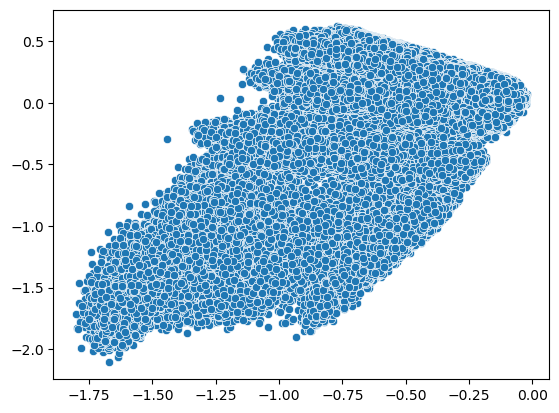

In [22]:
sns.scatterplot(x=X_KNN,y=Y_KNN)

## Clustering evaluation

In [29]:
test_knn.shape

(1000000, 2)

In [31]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

test_knn_array = np.array(test_knn)

X_train_norm = preprocessing.normalize(test_knn_array)

kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto')
kmeans.fit(X_train_norm)


test_knn_array_with_labels = np.column_stack((test_knn_array, kmeans.labels_))

df_with_labels = pd.DataFrame(test_knn_array_with_labels, columns=['feature1', 'feature2', 'cluster_labels'])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa46b436e60>
Traceback (most recent call last):
  File "/raid/home/labuserdia/.conda/envs/DLexp/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/raid/home/labuserdia/.conda/envs/DLexp/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/raid/home/labuserdia/.conda/envs/DLexp/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/raid/home/labuserdia/.conda/envs/DLexp/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


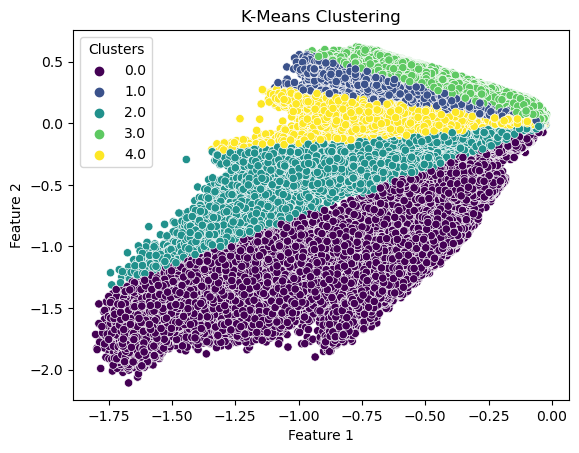

In [32]:
sns.scatterplot(x='feature1', y='feature2', hue='cluster_labels', data=df_with_labels, palette='viridis')

# Customize the plot (optional)
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Clusters')
plt.show()